<h1 align='center' style='color:purple'>Credit Card Fraud - Imbalanced Data Set</h1>

**Use Case:** Credit Card Fraud Detection

    Compare different common algorithms, develop and optimize new 2 sequential/consecutive model algorithm to see if this can give better results
    
**Author:** Donald Stierman

**Details:** I ran 4 different common model algorithms on the credit card dataset, including a modeling technique I developed that is similar to some Healthcare screening solutions currently in use. I.E. Breast Cancer detection in women. If a mammogram comes back positive, we know that there will be a lot of false positives (benign tumors, scars, etc) so the doctor will follow up with a 2nd test such as biopsy which will screen out the false positives leaving mostly true positives (cancerous tissue). 

**Here are some different ways to explain the methodology used in the Healthcare use case:**

*1st test (high specificity) -> 2nd test (high sensitivity) -> Only treat cancerous tissue

*TN/(TN + FP) is high ~ 1    -> TP/(TP + FN) is high ~ 1    -> Find all Positive cases

*catch all possible cases/remove healthy patients -> remove all false flags -> high confidence in Positive result/few missed positives


This same methodology can be applied to Credit Card Fraud detection

**Models used:**
    Logistic Regression
    Random Forest
    Gradient Boosted Decision Trees
    Customized 2 Step Gradient Boosted Decision Trees
    Deep Neural Network

**Goal:** 
I choose 2 goals or metrics to optimize, first is to find the best overall model (lowest mislabelled predictions), second is to find the model that has a low number of false negatives (faudulent transactions that are missed) without having too many false positives (genuine transactions that are needlessly investigated)

1) Increase the AUC to find the most robust model overall

2) Maximize the Sensitivity or reduce the number of False Negatives (FN/TP ratio). I.E. catch all the fraudulent transaction even if there are false flags (false positives).

**Results:** The Customized 2 Step model has the best results overall. 
                          
                                Sensitivity/Specificity
                          
    Logistic Regression         87/94
    Random Forest               89/97
    Gradient Boosted Tree       87/99
    Customized 2 Step GB Trees  93/99
    Deep Neural Network         92/90

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
import zipfile

import tensorflow as tf

In [2]:
colab = os.environ.get('COLAB_GPU', '10')
if (int(colab) == 0):
    from google.colab import drive
    drive.mount('/content/drive')
    #Path="drive/My Drive/Colab Notebooks/StockAnalysis"
    Path=""
    DataPath="/content"
    RootPath="/root"    
else:
    #Path="/c/DataScience/Repo/Imbalanced_data"
    Path="/DataScience/Repo/Imbalanced_data"
    DataPath=Path
    RootPath="/Users/iowahawk89"

In [3]:
with zipfile.ZipFile(DataPath+'/creditcard.zip', 'r') as zip_ref:
    zip_ref.extractall(Path)

In [4]:
# Load the Data Set
df = pd.read_csv('creditcard.csv')

Public Credit Card Dataset. This is financial data, and is considered to be sensitive so it is "encrypted" through the use of PCA to protect privacy. Only the Time and Dollar columns are intact after the "encryption"

In [5]:
# Check the data
print(df.head())

   Time_Series        V1        V2        V3        V4        V5        V6  \
0          0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1          0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2          1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3          1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4          2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount 

In [6]:
# Check the datatypes of the Data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time_Series  284807 non-null  float64
 1   V1           284807 non-null  float64
 2   V2           284807 non-null  float64
 3   V3           284807 non-null  float64
 4   V4           284807 non-null  float64
 5   V5           284807 non-null  float64
 6   V6           284807 non-null  float64
 7   V7           284807 non-null  float64
 8   V8           284807 non-null  float64
 9   V9           284807 non-null  float64
 10  V10          284807 non-null  float64
 11  V11          284807 non-null  float64
 12  V12          284807 non-null  float64
 13  V13          284807 non-null  float64
 14  V14          284807 non-null  float64
 15  V15          284807 non-null  float64
 16  V16          284807 non-null  float64
 17  V17          284807 non-null  float64
 18  V18          284807 non-

In [7]:
# Check the Uniqueness
df.nunique()

Time_Series    124592
V1             275663
V2             275662
V3             275663
V4             275662
V5             275662
V6             275662
V7             275662
V8             275661
V9             275662
V10            275659
V11            275662
V12            275662
V13            275663
V14            275662
V15            275661
V16            275661
V17            275662
V18            275662
V19            275661
V20            275661
V21            275660
V22            275661
V23            275659
V24            275662
V25            275661
V26            275661
V27            275659
V28            275653
Amount          32767
Class               2
dtype: int64

In [8]:
# Check for missing data
df.isnull().sum()

Time_Series    0
V1             0
V2             0
V3             0
V4             0
V5             0
V6             0
V7             0
V8             0
V9             0
V10            0
V11            0
V12            0
V13            0
V14            0
V15            0
V16            0
V17            0
V18            0
V19            0
V20            0
V21            0
V22            0
V23            0
V24            0
V25            0
V26            0
V27            0
V28            0
Amount         0
Class          0
dtype: int64

In [9]:
# Check basic Statistics

df.describe(include ='all')

,Time_Series,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,-2.971792e-14,2.531226e-14,-1.923049e-14,1.093810e-14,-6.677660e-14,1.285053e-14,-5.204238e-14,1.023695e-14,2.237256e-15,...,-3.823399e-14,9.996013e-14,8.036320e-15,3.042869e-14,-8.644179e-14,-9.235807e-14,-5.269689e-14,9.542474e-14,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781942e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
# Check the Class Imbalance of the Data 

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

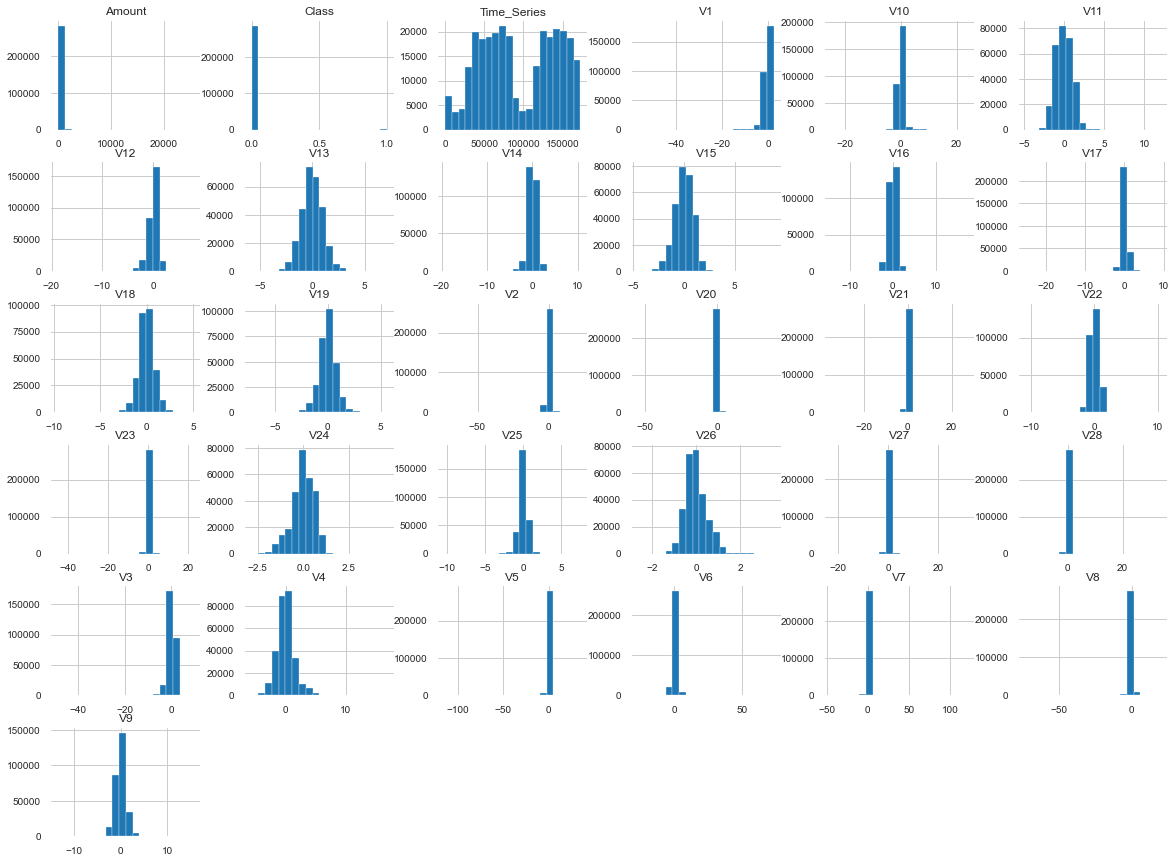

In [11]:
# Histograms of the features
# most of the data has a quasi-normal/gaussian distribution

df.hist(bins=20, figsize=(20,15))
plt.show()

Divide the dataset into features and labels and then into Train, Test and Validate datasets

In [12]:
# divide full data into features and label

X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
# Split the Data into Train and Test 

# create train, test and validate datasets

# first split original into Train and Test+Val
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size = 0.4, random_state = 42)
# then split Test+Val into Test and Validate
# Validate will only be used in the 2 Model system (explained below)
X_test, X_val, y_test, y_val = train_test_split(X_test1,y_test1, test_size = 0.4, random_state = 42)

class_names=[0,1] # name  of classes 1=fraudulent transaction

In [13]:
# find the number of minority (value=1) samples in our train set so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the train dataset
X_train = X_train.loc[undersample_ind]
y_train = y_train.loc[undersample_ind]

In [14]:
def visualize(Actual, Pred, Algo):
    #Confusion Matrix
    cnf_matrix=metrics.confusion_matrix(Actual, Pred) #

    #Visualize confusion matrix using heat map

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+Algo, y=1.1) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [15]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred, algo):
    try:
        print(model_name.score(test_features, test_label)) 
        print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
        print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    except Exception as e:
        print("error")  
    try:
        print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    except Exception as e:
        print("error") 
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    print("Specificity =", tn/(tn+fp))
    print("Sensitivity =", tp/(tp+fn))
    fpr, tpr, thresholds = metrics.roc_curve(test_label, pred, pos_label=1)
    # AUC score should be (Sensitivity+Specificity)/2
    print(algo + ':TEST | AUC Score: ' + str( round(metrics.auc(fpr, tpr),3 )))
    return tn, fp, fn, tp

In [20]:
def auc_roc_metrics(model, test_features, test_labels, algo):
    # useful for imbalanced data
    ns_probs = [0 for _ in range(len(test_labels))]
    
    # predict probabilities
    model_probs = model.predict_proba(test_features)
    # keep probabilities for the positive outcome only

    # model_probs = model_probs[:, 1] -> IndexError: index 1 is out of bounds for axis 1 with size 1
    # 
    # sklearn predict_proba will output 2 values per row, 1st is probability of 0, 2nd is 
    # probability of 1. Both will add up to 1, so 2nd = (1 - 1st)
    # a Neural Network usually returns the prediction for a 1 value, not both
    # need to handle this, since we only want the prediction of a value of 1 anyway
    # see https://stackoverflow.com/questions/41716380/keras-output-of-model-predict-proba for details
    n = model.predict_proba(X_test).shape[1]-1
    model_probs = model_probs[:, n]
    #UnboundLocalError: local variable 'model_probs' referenced before assignment
    
    # calculate scores
    ns_auc = roc_auc_score(test_labels, ns_probs) # no skill
    model_auc = round(roc_auc_score(test_labels, model_probs), 3)

    # summarize scores
    print('%10s : ROC AUC=%.3f' % ('No Skill',ns_auc))
    print('%10s : ROC AUC=%.3f' % (algo,model_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
    # NameError: name 'ns_probs' is not defined
    model_fpr, model_tpr, _ = roc_curve(test_labels, model_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(model_fpr, model_tpr, marker='.', label='%s (area = %0.2f)' % (algo, model_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    pyplot.title('Receiver Operating Characteristic curve')
    # show the plot
    pyplot.show()
    return model_auc

In [21]:
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [22]:
metrics_results = {}

run Logistic Regression model first

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9473176012757304
0.9473176012757304
Accuracy score (training): 0.929
Accuracy score (validation): 0.947
error
Confusion Matrix:
false positive pct: 5.247757962342545
tn  fp  fn  tp
64647 3587 14 105
[[64647  3587]
 [   14   105]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     68234
           1       0.03      0.88      0.06       119

    accuracy                           0.95     68353
   macro avg       0.51      0.91      0.51     68353
weighted avg       1.00      0.95      0.97     68353

Specificity = 0.9474308995515432
Sensitivity = 0.8823529411764706
LR:TEST | AUC Score: 0.915


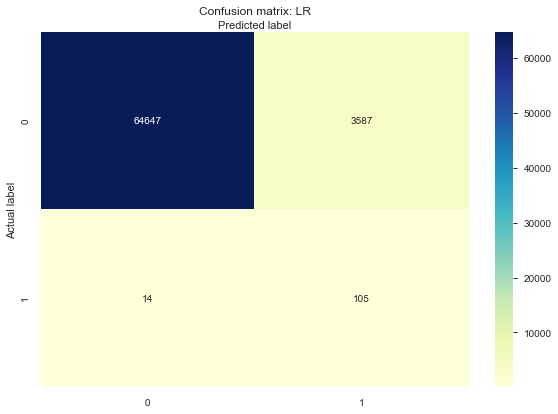

  No Skill : ROC AUC=0.500
        LR : ROC AUC=0.955


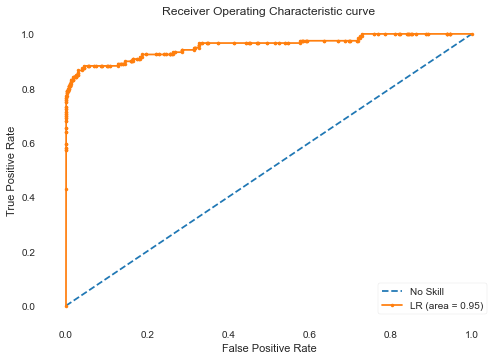

In [23]:
lr = LogisticRegression()
#lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
lr_Pred=lr.predict(X_test)

print(metrics.accuracy_score(y_test, lr_Pred))
tn, fp, fn, tp = display_metrics(lr, X_train, X_test, y_train, y_test, lr_Pred, 'LR')
visualize(y_test, lr_Pred, 'LR')
lr_auc = auc_roc_metrics(lr, X_test, y_test, 'LR')
metrics_results['lr'] = lr_auc

Logistic: f1=0.055 auc=0.455


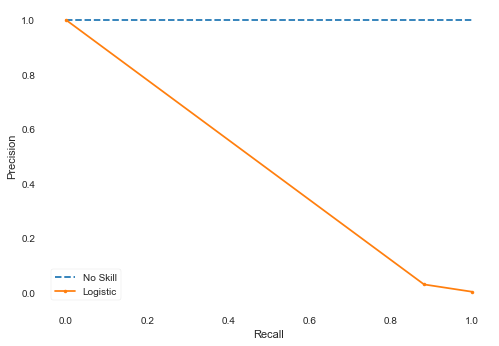

In [24]:
# useful for unbalanced data, maybe include later in metrics summary for all models

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_Pred)
lr_f1, lr_auc = f1_score(y_test, lr_Pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next try the Random Forest model

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     68234
           1       0.06      0.88      0.11       119

    accuracy                           0.97     68353
   macro avg       0.53      0.93      0.55     68353
weighted avg       1.00      0.97      0.99     68353

0.9740172340643425
Accuracy score (training): 1.000
Accuracy score (validation): 0.974
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 2.5777946834813394
tn  fp  fn  tp
66472 1762 14 105
[[66472  1762]
 [   14   105]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     68234
           1       0.06      0.88      0.11       119

    accuracy                           0.97     68353
   macro avg       0.53      0.93      0.55     68353
weighted avg       1.00      0.97      0.99     68353

Specificity = 0.9741770964621743
Sensitivity = 0.8823529411764706
RF:TEST | AUC

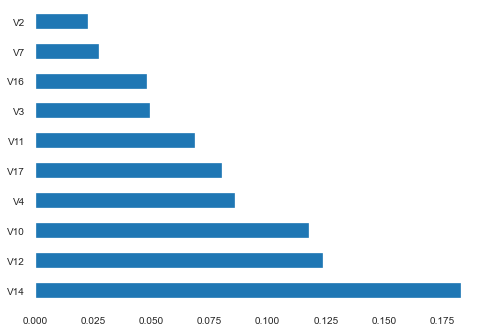

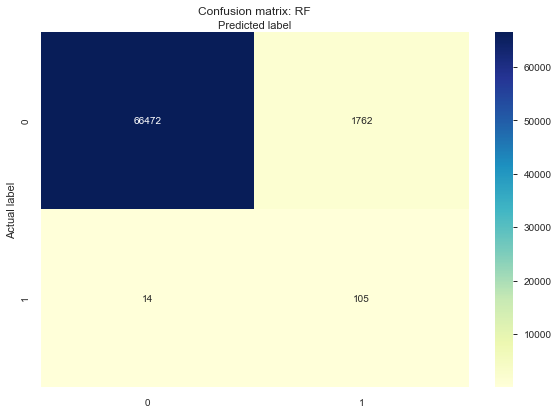

  No Skill : ROC AUC=0.500
        RF : ROC AUC=0.975


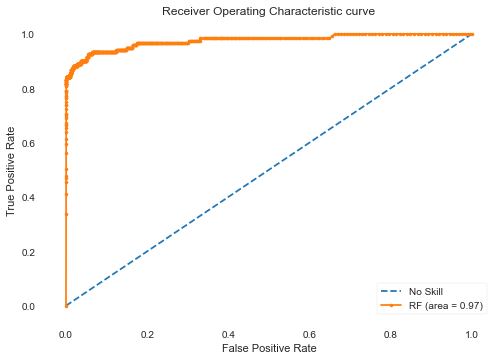

In [25]:
rf = RandomForestClassifier(n_estimators = 1000)

rf.fit(X_train, y_train)

rf_Pred=rf.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf_Pred))
tn, fp, fn, tp = display_metrics(rf, X_train, X_test, y_train, y_test, rf_Pred, 'RF')
visualize(y_test, rf_Pred, 'RF')
rf_auc = auc_roc_metrics(rf, X_test, y_test, 'RF')
metrics_results['rf'] = rf_auc

So far, logistic regression has better prediction capability, the RandomForestClassifier test has a lot more mistakes in the False Positive category, and only a few less mistakes in the False Negative category.

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9870232469679459
Accuracy score (training): 0.937
Accuracy score (validation): 0.987
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 1.2728044123886295
tn  fp  fn  tp
67364 870 17 102
[[67364   870]
 [   17   102]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     68234
           1       0.10      0.86      0.19       119

    accuracy                           0.99     68353
   macro avg       0.55      0.92      0.59     68353
weighted avg       1.00      0.99      0.99     68353

Specificity = 0.987249758185069
Sensitivity = 0.8571428571428571
GB:TEST | AUC Score: 0.922


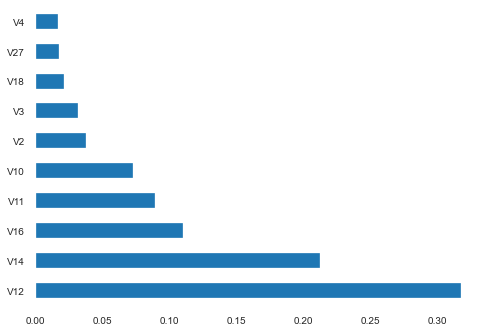

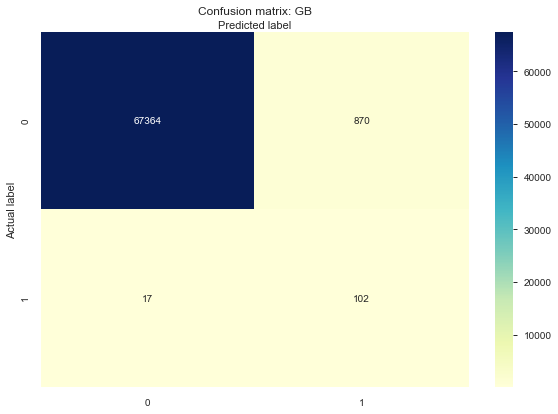

  No Skill : ROC AUC=0.500
        GB : ROC AUC=0.967


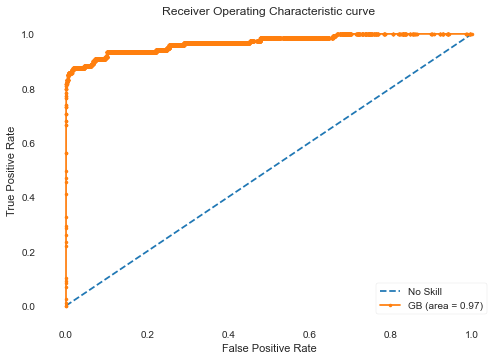

In [26]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=0, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly
gb_clf.fit( X_train, y_train, sample_weight=np.where(y_train == 1,0.5,1.0) ) #  fn = 12 and fp = 1057
# no weights gives worse false positive counts
#gb_clf.fit( X_train, y_train) # fn = 8 and fp = 2639

#use model to predict validation dataset
predictions = gb_clf.predict(X_test)

tn, fp, fn, tp = display_metrics(gb_clf, X_train, X_test, y_train, y_test, predictions, 'GB')
visualize(y_test, predictions, 'GB')
gb_auc = auc_roc_metrics(gb_clf, X_test, y_test, 'GB')
metrics_results['gb'] = gb_auc

After tweaking the parameters, i get a better result from GradientBoostingClassifier. Changing the weights has a very large influence on the number of errors (FN and FP). Decreasing the weight of a true value vs a false value will decrease the FN, doing the opposite will decrease the FP. For example:  the sample_weight=np.where(y_train == 1,0.37,1.0) gives 13 FN and 795 FP. sample_weight=np.where(y_train == 1,0.1,1.0) gives 17 FN and 217 FP

My next idea is to run 2 consecutive models consecutively. 1st model should have low false negatives to catch (almost) all the actual positives, even if the number of false positives is high. Then only take these records with a predicted 1 value (should only be a few thousand), as the input for the next model. 2nd test should have low false positives to weed out the actual negatives. Will use the Validate dataset on the 2 models created from the Train and Test datasets

Current:
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M2(Filtered Test)
                Test
                
To Do:               
Full Dataset -> Train -> Build M1(Train) -> Run M1(Test) -> Filter(Predicted 1's from Test) -> Build M2 -> run M1 and M2(Validate)
                Test
                Validate

Can also try the inverse, but think that option will have less chance of success.

1st step

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8803563852354688
Accuracy score (training): 0.967
Accuracy score (validation): 0.880
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 11.95558351498837
tn  fp  fn  tp
60062 8172 6 113
[[60062  8172]
 [    6   113]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     68234
           1       0.01      0.95      0.03       119

    accuracy                           0.88     68353
   macro avg       0.51      0.91      0.48     68353
weighted avg       1.00      0.88      0.93     68353

Specificity = 0.8802356596418208
Sensitivity = 0.9495798319327731
GB1:TEST | AUC Score: 0.915


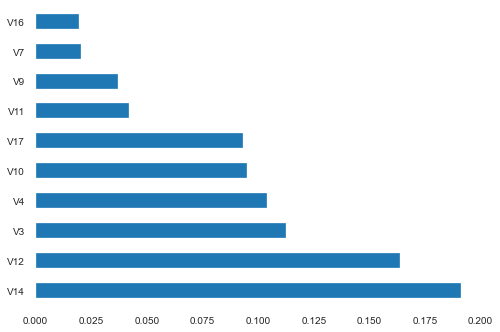

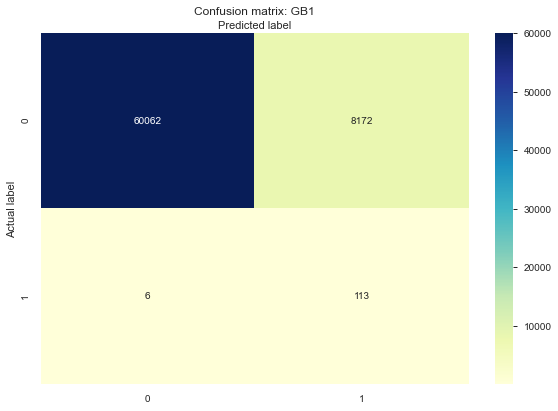

  No Skill : ROC AUC=0.500
       GB1 : ROC AUC=0.973


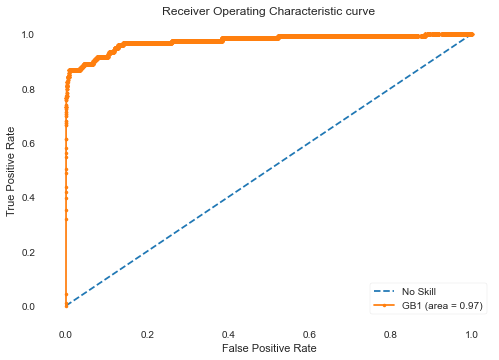

In [27]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=0, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf1.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important, also more rare
gb_clf1.fit( X_train, y_train, sample_weight=np.where(y_train == 1,4.0,1.0) ) # was 5.0

#use model to predict validation dataset
predictions = gb_clf1.predict(X_test) 

tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_train, X_test, y_train, y_test, predictions, 'GB1')
visualize(y_test, predictions, 'GB1')
gb1_auc = auc_roc_metrics(gb_clf1, X_test, y_test, 'GB1')
metrics_results['gb1'] = gb1_auc

2nd step takes all the Predicted Positives (the misclassified FP from upper right (~ 14000) plus the TP (since we won't use the actual value until the validation step)) and reprocesses these using a different model. The other 2 squares (Predicted 0's) are not included in the 2nd model, since we already have a low False negative result, so the initial predicted 0s don't change. Will need to add those back into the final results at the end.

Add 1st model prediction column to X_test for filtering

In [28]:
X_test['Prediction'] = predictions

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


select rows with prediction of 1

In [29]:
yes_ind = X_test[X_test['Prediction'] == 1].index

Create 2nd train dataset from 1st dataset where the prediction was 1

In [30]:
X2_test = X_test.loc[yes_ind]
y2_test = y_test.loc[yes_ind]
X2_test = X2_test.drop(['Prediction'], axis=1)

run the 2nd model

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.96016898008449
Accuracy score (training): 0.930
Accuracy score (validation): 0.960
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 3.789981894990947
tn  fp  fn  tp
7858 314 16 97
[[7858  314]
 [  16   97]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8172
           1       0.24      0.86      0.37       113

    accuracy                           0.96      8285
   macro avg       0.62      0.91      0.67      8285
weighted avg       0.99      0.96      0.97      8285

Specificity = 0.9615761135584924
Sensitivity = 0.8584070796460177
GB2:TEST | AUC Score: 0.91


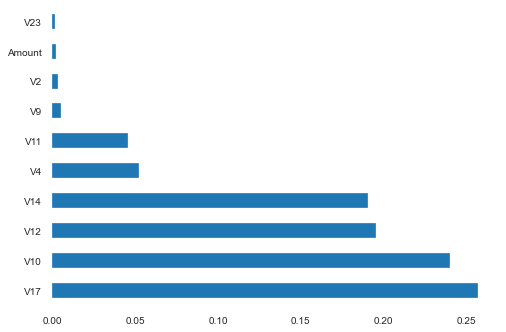

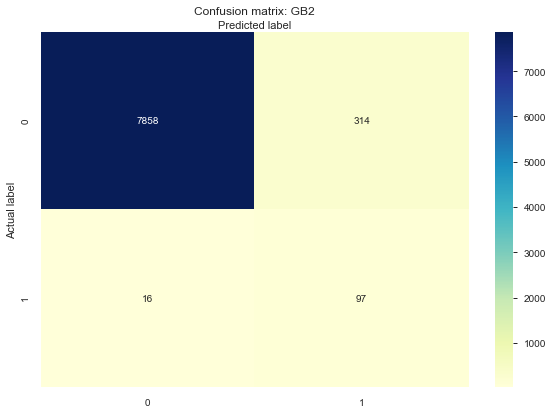

2 Step Final Confusion Matrix:
67920 314
22 97


Text(0.5, 352.48, 'Predicted label')

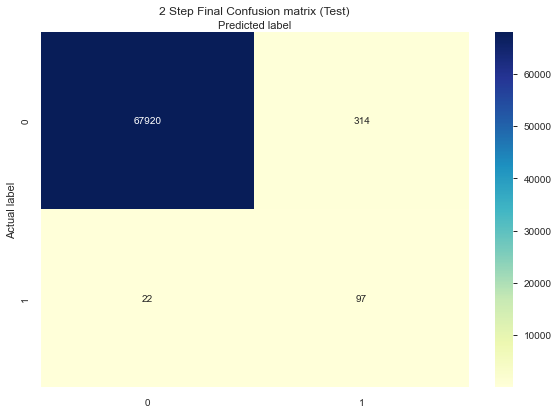

In [31]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=10, 
                                    max_depth=3, random_state=0, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf2.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important
# note that the weights in the 2nd model are the inverse of the weights in the 1st model
gb_clf2.fit( X_train, y_train, sample_weight=np.where(y_train == 1,0.2,1.0) ) # was 0.1

#use model to predict validation dataset
predictions = gb_clf2.predict(X2_test) 

tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_test, y_train, y2_test, predictions, 'GB2')

visualize(y2_test, predictions, 'GB2')

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Test)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

In [32]:
predictions1 = gb_clf1.predict(X_val)
X_test = X_test.drop(['Prediction'], axis=1)

error
0.8829931972789116
Accuracy score (training): 0.880
Accuracy score (validation): 0.883
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 11.696291419793724
tn  fp  fn  tp
40168 5330 2 70
[[40168  5330]
 [    2    70]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     45498
           1       0.01      0.97      0.03        72

    accuracy                           0.88     45570
   macro avg       0.51      0.93      0.48     45570
weighted avg       1.00      0.88      0.94     45570

Specificity = 0.8828519934942195
Sensitivity = 0.9722222222222222
GB1:TEST | AUC Score: 0.928
0.9607407407407408
Accuracy score (training): 0.930
Accuracy score (validation): 0.961
AxesSubplot(0.125,0.125;0.775x0.755)
Confusion Matrix:
false positive pct: 3.8703703703703707
tn  fp  fn  tp
5121 

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


209 3 67
[[5121  209]
 [   3   67]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      5330
           1       0.24      0.96      0.39        70

    accuracy                           0.96      5400
   macro avg       0.62      0.96      0.68      5400
weighted avg       0.99      0.96      0.97      5400

Specificity = 0.9607879924953096
Sensitivity = 0.9571428571428572
GB2:TEST | AUC Score: 0.959


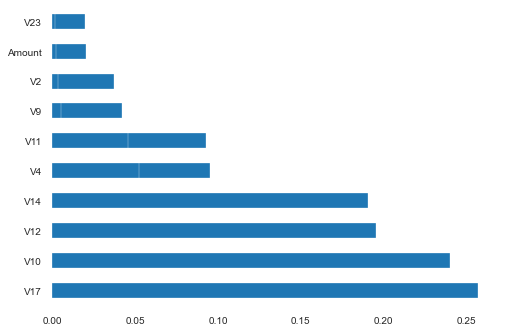

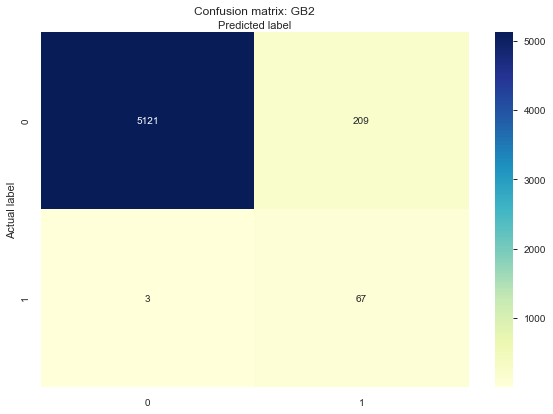

2 Step Final Confusion Matrix:
45289 209
5 67
Specificity = 0.9954063914897359
Sensitivity = 0.9305555555555556
2 Step Algorithm:TEST | AUC Score: 0.963


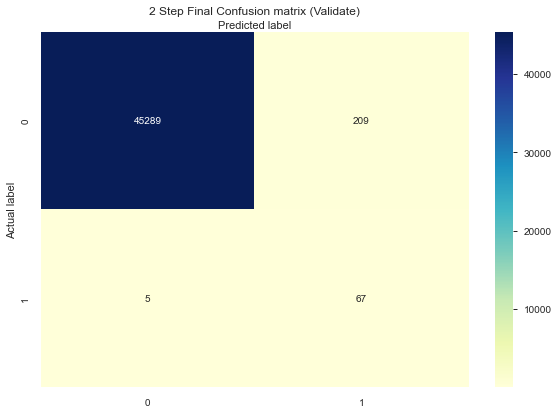

In [33]:
# adding this
#use models to predict validation dataset
try:
    X_val = X_val.drop(['Prediction'], axis=1)
except Exception as e:
    print("error")

tn1, fp1, fn1, tp1 = display_metrics(gb_clf1, X_test, X_val, y_test, y_val, predictions1, 'GB1') 

X_val['Prediction'] = predictions1

yes_ind = X_val[X_val['Prediction'] == 1].index

X2_val = X_val.loc[yes_ind]
y2_val = y_val.loc[yes_ind]
X2_val = X2_val.drop(['Prediction'], axis=1)

predictions2 = gb_clf2.predict(X2_val) 

tn, fp, fn, tp = display_metrics(gb_clf2, X_train, X2_val, y_train, y2_val, predictions2, 'GB2') 
visualize(y2_val, predictions2, 'GB2')

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix (Validate)', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

Specificity = (tn+tn1)/(tn+tn1+fp)
Sensitivity = tp/(tp+fn+fn1)

print("Specificity =", Specificity)
print("Sensitivity =", Sensitivity)

print('2 Step Algorithm' + ':TEST | AUC Score: ' + str( round( (Specificity+Sensitivity)/2,3 )))

# HERE
#two_step_auc = auc_roc_metrics(gb_clf, X_test, y_test, '2-Step')

The 2 step process has the highest sensitivity (and specificity) between the models. The 2 step process also improves the overall model prediction of positives by a large amount (FP/TP ratio from above 10x to below 2x). I don't think we could get this high of precision and recall together with a single model. The best I could do with a single model was 10x FP/TP ratio.

Next will try Neural Networks

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


In [35]:
# prepare data for model
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
def create_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(20, kernel_initializer='uniform', activation='relu'),
        Dense(24, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [37]:
def create_simple_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [38]:
def create_complex_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=20, kernel_initializer='uniform', activation='relu'),
        Dense(units=24, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
____________________________________________________

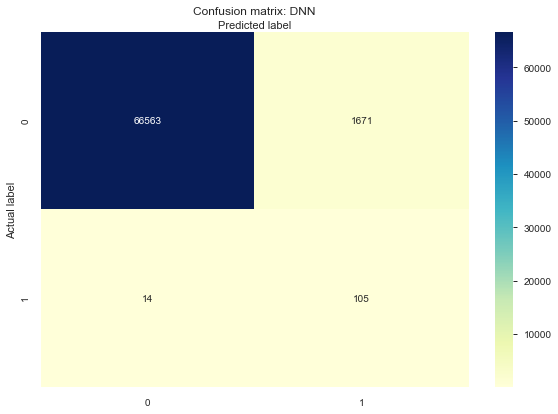

  No Skill : ROC AUC=0.500
       DNN : ROC AUC=0.981


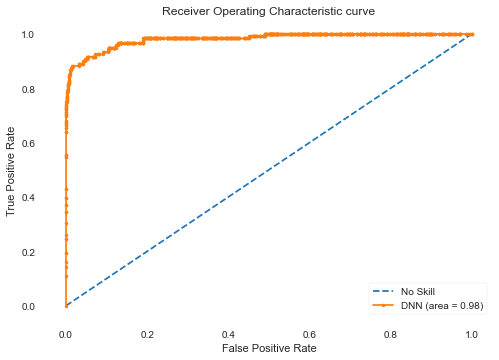

In [39]:
clf = create_dnn()
clf.summary()
#clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adam = keras.optimizers.Adam(learning_rate=0.001)
# try using focal_loss to give heavier weight to examples that are difficult to classify
# seems to improve the metrics slightly
clf.compile(optimizer=adam, loss=[focal_loss], metrics=['accuracy'])
#clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,0.2,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=20, sample_weight=np.where(y_train == 1,4.0,1.0).flatten())

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN')
visualize(y_test, yhat_classes, 'DNN')
dnn_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN')
metrics_results['dnn'] = dnn_auc

Results from Deep NN are better than 1 step/model examples, but overall not quite as good as the 2 step/model process. I can get the sensitivity to be as good, but in that case, the specificity is much lower. As more data is added or processed through this DNN, the results should improve, maybe eventually beating the 2 step model. However, it seems that increasing the number of epochs will weight the model to higher false negatives, similar to using sample weights for the GBM model:

**sample_weight=np.where(y_train == 1,0.1,1.0)**

**giving a 1 in the training data 10 times the weight or inflence of a 0**

For now, we will keep the number of epochs at 5.
Weighting has the same effect on this DNN as it had on the GBM. Best all around result with 

sample_weight=np.where(y_train == 1,0.1,1.0).flatten()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_7 (Dense)              (None, 18)                306       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 19        
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
602/602 [==============================] - 0s 259us/step - loss: 1.7226 - accuracy: 0.5150
Epoch 2/32
602/602 [==============================] - 0s 75us/step - loss: 1.6773 - accuracy: 0.5000
Epoch 3/32
602/602 [==============================] - 0s 70us/step - loss: 1.5383 - accuracy: 0.5000
Epoch 4/32
602/602 [==============================] - 0s 65us/step - loss: 1.2734 

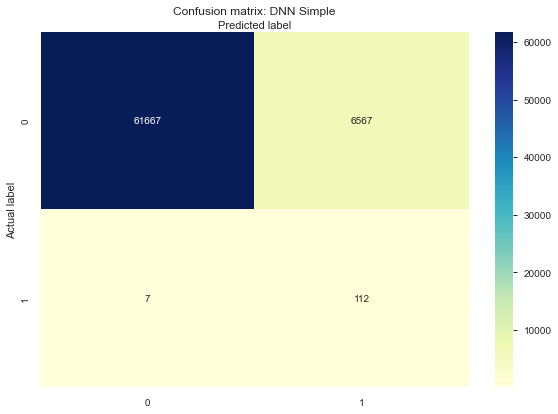

  No Skill : ROC AUC=0.500
DNN-Simple : ROC AUC=0.981


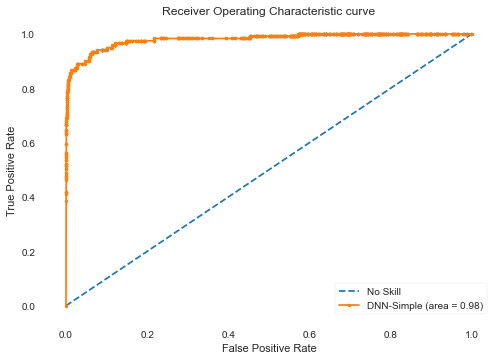

In [40]:
clf = create_simple_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=32, epochs=32, sample_weight=np.where(y_train == 1,4.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN Simple)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Simple')
visualize(y_test, yhat_classes, 'DNN Simple')
dnn_simple_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Simple')
metrics_results['dnn_simple'] = dnn_simple_auc

This DNN is successful at reducing the FP/TP ratio. This is expected as a Neural Network can decide on its own rules to include based on the input data. Below I try other more and less complex methods, but so far the results are not as good.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_10 (Dense)             (None, 18)                306       
_________________________________________________________________
dropout_2 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 30)                570       
_________________________________________________________________
dense_12 (Dense)             (None, 28)                868       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)               

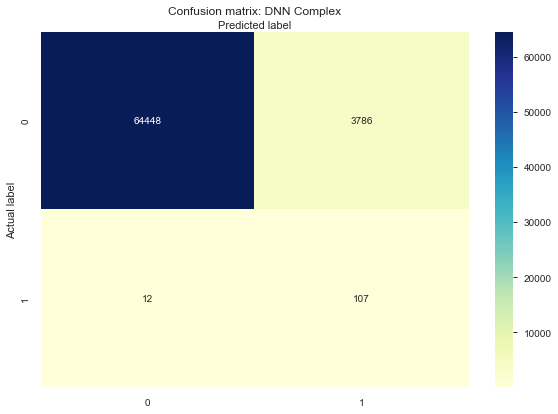

  No Skill : ROC AUC=0.500
DNN-Complex : ROC AUC=0.944


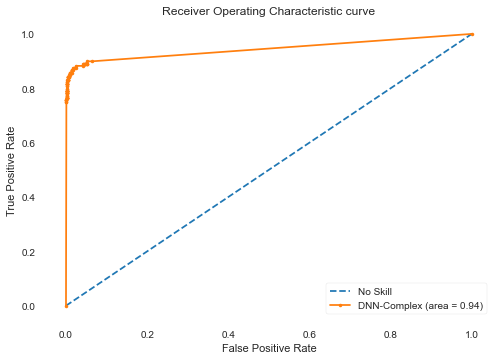

In [41]:
clf = create_complex_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,4.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN complex)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'DNN Complex')
visualize(y_test, yhat_classes, 'DNN Complex')
dnn_complex_auc = auc_roc_metrics(clf, X_test, y_test, 'DNN-Complex')
metrics_results['dnn_complex'] = dnn_complex_auc

In [42]:
def create_autoencoder():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=14, kernel_initializer='uniform', input_dim=30, activation='tanh', activity_regularizer=regularizers.l1(10e-5)),
        Dense(units=7, kernel_initializer='uniform', activation='relu'),
        Dense(units=7, kernel_initializer='uniform', activation='tanh'),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 14)                434       
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_21 (Dense)             (None, 30)                240       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 31        
Total params: 866
Trainable params: 866
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
602/602 [==============================] - 0s 406us/step - loss: 0.6127 - accuracy: 0.5017
Epoch 2/32
602/602 [

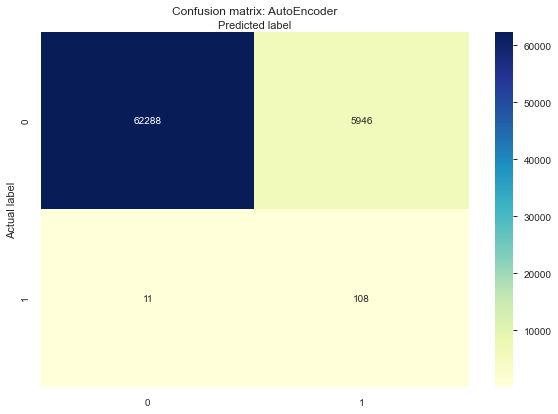

  No Skill : ROC AUC=0.500
AutoEncoder : ROC AUC=0.964


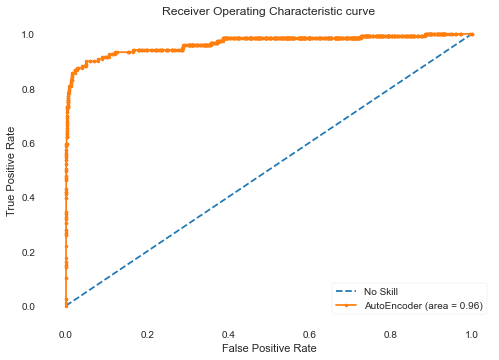

In [43]:
clf = create_autoencoder()
clf.summary()
clf.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create/fit model on the training dataset
#clf.fit(X_train, y_train, batch_size=32, epochs=32, shuffle=True)#, validation_data=(X_test, X_test))
clf.fit(X_train, y_train, batch_size=16, epochs=32, sample_weight=np.where(y_train == 1,4.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=32, epochs=32, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=32)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=32)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (AutoEncoder)") 
print(classification_report(y_test, yhat_classes))
tn, fp, fn, tp = display_metrics(clf, X_train, X_test, y_train, y_test, yhat_classes, 'AutoEncoder')
visualize(y_test, yhat_classes, 'AutoEncoder')
autoencoder_auc = auc_roc_metrics(clf, X_test, y_test, 'AutoEncoder')
metrics_results['autoencoder'] = autoencoder_auc

In [44]:
print(metrics_results)

{'lr': 0.955, 'rf': 0.975, 'gb': 0.967, 'gb1': 0.973, 'dnn': 0.981, 'dnn_simple': 0.981, 'dnn_complex': 0.944, 'autoencoder': 0.964}
